<a href="https://colab.research.google.com/github/deepskandpal/hands-on-machine-learning/blob/POC/fake-news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install contractions
!pip install fasttext
!pip install pyLDAvis

     |████████████████████████████████| 317kB 2.6MB/s 
     |████████████████████████████████| 245kB 5.3MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81699 sha256=065ab7dfdef1ede5c94cca487ce8126e0873d0c59ea5cf6dafb3265040e452f8
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick
     |████████████████████████████████| 71kB 1.5MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3014376 sha256=fec8237d74cfae9d1ea12cde451edb3918307465df8d8a4be7d1927937487de5
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext
     |████████████████████████████████| 1.6MB 1.7MB/s 
     |████████████████████████████████| 552kB 12.0MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=7948cc31f8a8f31

In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import nltk
import string
import fasttext
import contractions
import matplotlib as plt
import pyLDAvis.sklearn
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)
%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [31]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"atdeepanshu","key":"efb7cfbda38df5a60eec6e85835e4859"}'}

In [32]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [33]:
!kaggle competitions download -c fake-news


100% 9.42M/9.42M [00:00<00:00, 98.5MB/s]

 84% 31.0M/37.0M [00:00<00:00, 43.8MB/s]
100% 37.0M/37.0M [00:00<00:00, 83.5MB/s]
  0% 0.00/40.6k [00:00<?, ?B/s]
100% 40.6k/40.6k [00:00<00:00, 41.0MB/s]


In [34]:
!ls

'<'	       ''$'\372\274'			    ''$'\276''Plattsmier '
'='	       ''$'\201\276'			    'rmedahl '
'>'	       ''$'\017''='			    'rts '
'?'	       ''$'\025\276'			    'S'$'\275'
''$'\276'      '5'$'\276'			     sample_data
''$'\275'      ''$'\314''7'			    'Sigalla '
''$'\274'      'd'$'\276'			     similar_words.png
''$'\341''<'   'display '			     submit.csv
''$'\277''='    GoogleNews-vectors-negative300.bin  'ternational '
''$'\211\275'   kaggle.json			     test.csv.zip
''$'\357\275'  '>M_spud_#-##-## '		     train.csv.zip


In [35]:
train_data = pd.read_csv('train.csv.zip')

In [18]:
train_data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Luc...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart",Daniel J. Flynn,Ever get the feeling your life circles the roundabout rather than heads in a straight line towar...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, 2016 \nThe tension between intelligence analysts a...",1
3,3,15 Civilians Killed In Single US Airstrike Have Been Identified,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstrike Have Been Identified The rate at which civilia...,1
4,4,Iranian woman jailed for fictional unpublished story about woman stoned to death for adultery,Howard Portnoy,Print \nAn Iranian woman has been sentenced to six years in prison after Iran’s Revolutionary Gu...,1


In [36]:

authors = train_data["author"].value_counts()



In [37]:
train_data["text"][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

In [38]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [39]:
def pandas_profile(df):
    print(train_data.describe())
    print(train_data.info())
    from pandas_profiling import ProfileReport
    prof = ProfileReport(df)
    prof.to_file(output_file='report.html')

In [ ]:
from IPython.display import HTML
report = './report.html'
HTML(filename=report)

In [40]:
train_data.describe()

,id,label
count,20800.000000,20800.000000
mean,10399.500000,0.500625
std,6004.587135,0.500012
min,0.000000,0.000000
25%,5199.750000,0.000000
50%,10399.500000,1.000000
75%,15599.250000,1.000000
max,20799.000000,1.000000


In [41]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [42]:
def create_sequences(text):
    from tensorflow.keras.preprocessing.text import Tokenizer
    tok = Tokenizer()
    tok.fit_on_texts(text)
    sequence = tok.texts_to_sequences(text)
    return sequence
    

In [43]:
def clean_data(sentence):
    if isinstance(sentence, str):
        clean_sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence)
        return clean_sentence
    else:
        raise ValueError("error in sentence", sentence)

In [44]:
train_data.dropna(subset = ["text"], inplace=True)
train_data['text'].apply(clean_data)


0        House Dem Aide We Didn t Even See Comey s Letter Until Jason Chaffetz Tweeted It By Darrell Lucu...
1        Ever get the feeling your life circles the roundabout rather than heads in a straight line towar...
2        Why the Truth Might Get You Fired October 29 2016 The tension between intelligence analysts and ...
3        Videos 15 Civilians Killed In Single US Airstrike Have Been Identified The rate at which civilia...
4        Print An Iranian woman has been sentenced to six years in prison after Iran s Revolutionary Guar...
                                                        ...                                                 
20795    Rapper T I unloaded on black celebrities who met with Donald Trump after the election saying the...
20796    When the Green Bay Packers lost to the Washington Redskins in Week 11 dropping to Aaron Rodgers ...
20797    The Macy s of today grew from the union of several great names in American retailing including i...
20798    NATO Russi

In [45]:
train_data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Luc...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart",Daniel J. Flynn,Ever get the feeling your life circles the roundabout rather than heads in a straight line towar...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, 2016 \nThe tension between intelligence analysts a...",1
3,3,15 Civilians Killed In Single US Airstrike Have Been Identified,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstrike Have Been Identified The rate at which civilia...,1
4,4,Iranian woman jailed for fictional unpublished story about woman stoned to death for adultery,Howard Portnoy,Print \nAn Iranian woman has been sentenced to six years in prison after Iran’s Revolutionary Gu...,1


In [46]:
def split_sentence(sentence):
    if isinstance(sentence, str):
        return sentence.split()

def join_sentence(sentence):
    return ' '.join(sentence)

### T-SNE Visualization POC

In [2]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"


--2020-09-17 10:14:35--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.162.237
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.162.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  68.8MB/s    in 24s     

2020-09-17 10:14:59 (65.9 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [12]:
!ls
!sudo apt install gzip
!gzip -d GoogleNews-vectors-negative300.bin.gz

'<'	       ''$'\357\275'			       '>M_spud_#-##-## '
'='	       ''$'\372\274'			       ''$'\276''Plattsmier '
'>'	       ''$'\201\276'			       'rmedahl '
'?'	       ''$'\017''='			       'rts '
''$'\276'      ''$'\025\276'			       'S'$'\275'
''$'\275'      '5'$'\276'			        sample_data
''$'\274'      ''$'\314''7'			       'Sigalla '
''$'\341''<'   'd'$'\276'			       'ternational '
''$'\277''='   'display '
''$'\211\275'   GoogleNews-vectors-negative300.bin.gz
Reading package lists... Done
Building dependency tree       
Reading state information... Done
gzip is already the newest version (1.6-5ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [13]:
!ls

'<'	       ''$'\357\275'			    '>M_spud_#-##-## '
'='	       ''$'\372\274'			    ''$'\276''Plattsmier '
'>'	       ''$'\201\276'			    'rmedahl '
'?'	       ''$'\017''='			    'rts '
''$'\276'      ''$'\025\276'			    'S'$'\275'
''$'\275'      '5'$'\276'			     sample_data
''$'\274'      ''$'\314''7'			    'Sigalla '
''$'\341''<'   'd'$'\276'			    'ternational '
''$'\277''='   'display '
''$'\211\275'   GoogleNews-vectors-negative300.bin


In [14]:
import gensim

model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [15]:
import re
import codecs


def preprocess_text(text):
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()


def prepare_for_w2v(filename_from, filename_to, lang):
    raw_text = codecs.open(filename_from, "r", encoding='windows-1251').read()
    with open(filename_to, 'w', encoding='utf-8') as f:
        for sentence in nltk.sent_tokenize(raw_text, lang):
            print(preprocess_text(sentence.lower()), file=f)

In [16]:
import multiprocessing
from gensim.models import Word2Vec


def train_word2vec(filename):
    data = gensim.models.word2vec.LineSentence(filename)
    return Word2Vec(data, size=200, window=5, min_count=5, workers=multiprocessing.cpu_count())


In [17]:
keys = ['Paris', 'Python', 'Sunday', 'Tolstoy', 'Twitter', 'bachelor', 'delivery', 'election', 'expensive',
        'experience', 'financial', 'food', 'iOS', 'peace', 'release', 'war']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [18]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

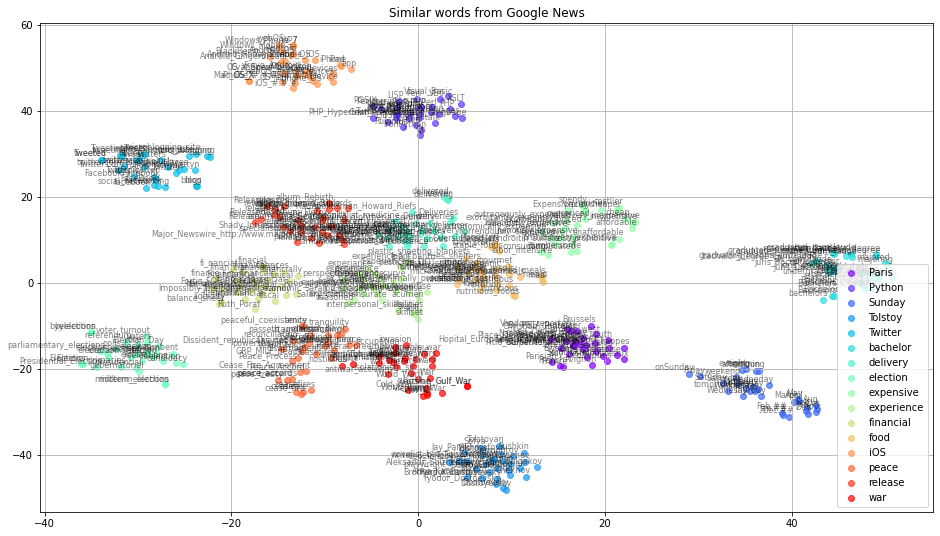

In [56]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
% matplotlib inline


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from Google News', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

In [23]:
model.most_similar('paris')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('heidi', 0.5592167377471924),
 ('london', 0.5555774569511414),
 ('france', 0.5550795197486877),
 ('dubai', 0.5532331466674805),
 ('samuel', 0.5494195222854614),
 ('hilton', 0.547286868095398),
 ('rome', 0.5465837717056274),
 ('toronto', 0.5457152724266052),
 ('las_vegas', 0.5441739559173584),
 ('lindsay_lohan', 0.542733907699585)]

### T-SNE visualization for Fake News

In [47]:
train_data['text_split'] = train_data['text'].apply(split_sentence)

In [48]:
train_data['text_split']

0        [House, Dem, Aide:, We, Didn’t, Even, See, Comey’s, Letter, Until, Jason, Chaffetz, Tweeted, It,...
1        [Ever, get, the, feeling, your, life, circles, the, roundabout, rather, than, heads, in, a, stra...
2        [Why, the, Truth, Might, Get, You, Fired, October, 29,, 2016, The, tension, between, intelligenc...
3        [Videos, 15, Civilians, Killed, In, Single, US, Airstrike, Have, Been, Identified, The, rate, at...
4        [Print, An, Iranian, woman, has, been, sentenced, to, six, years, in, prison, after, Iran’s, Rev...
                                                        ...                                                 
20795    [Rapper, T., I., unloaded, on, black, celebrities, who, met, with, Donald, Trump, after, the, el...
20796    [When, the, Green, Bay, Packers, lost, to, the, Washington, Redskins, in, Week, 11,, dropping, t...
20797    [The, Macy’s, of, today, grew, from, the, union, of, several, great, names, in, American, retail...
20798    [NATO,, Ru

In [49]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
train_data['stopwords_removed'] = train_data['text_split'].apply(lambda x: [word for word in x if word not in stop_words])
train_data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,id,title,author,text,label,text_split,stopwords_removed
0,0,House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Luc...,1,"[House, Dem, Aide:, We, Didn’t, Even, See, Comey’s, Letter, Until, Jason, Chaffetz, Tweeted, It,...","[House, Dem, Aide:, We, Didn’t, Even, See, Comey’s, Letter, Until, Jason, Chaffetz, Tweeted, It,..."
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart",Daniel J. Flynn,Ever get the feeling your life circles the roundabout rather than heads in a straight line towar...,0,"[Ever, get, the, feeling, your, life, circles, the, roundabout, rather, than, heads, in, a, stra...","[Ever, get, feeling, life, circles, roundabout, rather, heads, straight, line, toward, intended,..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, 2016 \nThe tension between intelligence analysts a...",1,"[Why, the, Truth, Might, Get, You, Fired, October, 29,, 2016, The, tension, between, intelligenc...","[Why, Truth, Might, Get, You, Fired, October, 29,, 2016, The, tension, intelligence, analysts, p..."
3,3,15 Civilians Killed In Single US Airstrike Have Been Identified,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstrike Have Been Identified The rate at which civilia...,1,"[Videos, 15, Civilians, Killed, In, Single, US, Airstrike, Have, Been, Identified, The, rate, at...","[Videos, 15, Civilians, Killed, In, Single, US, Airstrike, Have, Been, Identified, The, rate, ci..."
4,4,Iranian woman jailed for fictional unpublished story about woman stoned to death for adultery,Howard Portnoy,Print \nAn Iranian woman has been sentenced to six years in prison after Iran’s Revolutionary Gu...,1,"[Print, An, Iranian, woman, has, been, sentenced, to, six, years, in, prison, after, Iran’s, Rev...","[Print, An, Iranian, woman, sentenced, six, years, prison, Iran’s, Revolutionary, Guard, searche..."


In [50]:
words = train_data['stopwords_removed']
allwords = []
for wordlist in words:
    allwords += wordlist

In [51]:
train_data['text_processed'] = train_data['stopwords_removed'].apply(join_sentence)

In [52]:
train_data['text_processed']

0        House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Luc...
1        Ever get feeling life circles roundabout rather heads straight line toward intended destination?...
2        Why Truth Might Get You Fired October 29, 2016 The tension intelligence analysts political polic...
3        Videos 15 Civilians Killed In Single US Airstrike Have Been Identified The rate civilians killed...
4        Print An Iranian woman sentenced six years prison Iran’s Revolutionary Guard searched home found...
                                                        ...                                                 
20795    Rapper T. I. unloaded black celebrities met Donald Trump election, saying failed challenge presi...
20796    When Green Bay Packers lost Washington Redskins Week 11, dropping Aaron Rodgers vowed “run table...
20797    The Macy’s today grew union several great names American retailing, including namesake chain, Bl...
20798    NATO, Russ

In [53]:
allwords

['House',
 'Dem',
 'Aide:',
 'We',
 'Didn’t',
 'Even',
 'See',
 'Comey’s',
 'Letter',
 'Until',
 'Jason',
 'Chaffetz',
 'Tweeted',
 'It',
 'By',
 'Darrell',
 'Lucus',
 'October',
 '30,',
 '2016',
 'Subscribe',
 'Jason',
 'Chaffetz',
 'stump',
 'American',
 'Fork,',
 'Utah',
 '(',
 'image',
 'courtesy',
 'Michael',
 'Jolley,',
 'available',
 'Creative',
 'Commons-BY',
 'license)',
 'With',
 'apologies',
 'Keith',
 'Olbermann,',
 'doubt',
 'Worst',
 'Person',
 'The',
 'World',
 'week–FBI',
 'Director',
 'James',
 'Comey.',
 'But',
 'according',
 'House',
 'Democratic',
 'aide,',
 'looks',
 'like',
 'also',
 'know',
 'second-worst',
 'person',
 'well.',
 'It',
 'turns',
 'Comey',
 'sent',
 'now-infamous',
 'letter',
 'announcing',
 'FBI',
 'looking',
 'emails',
 'may',
 'related',
 'Hillary',
 'Clinton’s',
 'email',
 'server,',
 'ranking',
 'Democrats',
 'relevant',
 'committees',
 'didn’t',
 'hear',
 'Comey.',
 'They',
 'found',
 'via',
 'tweet',
 'one',
 'Republican',
 'committee',
 'ch

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

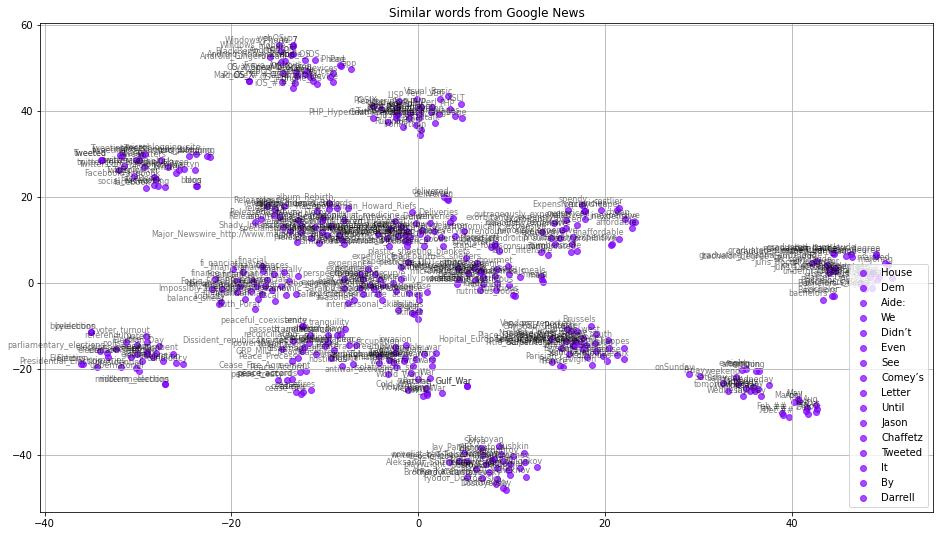

In [54]:
tsne_plot_similar_words('Similar words from Google News', allwords, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

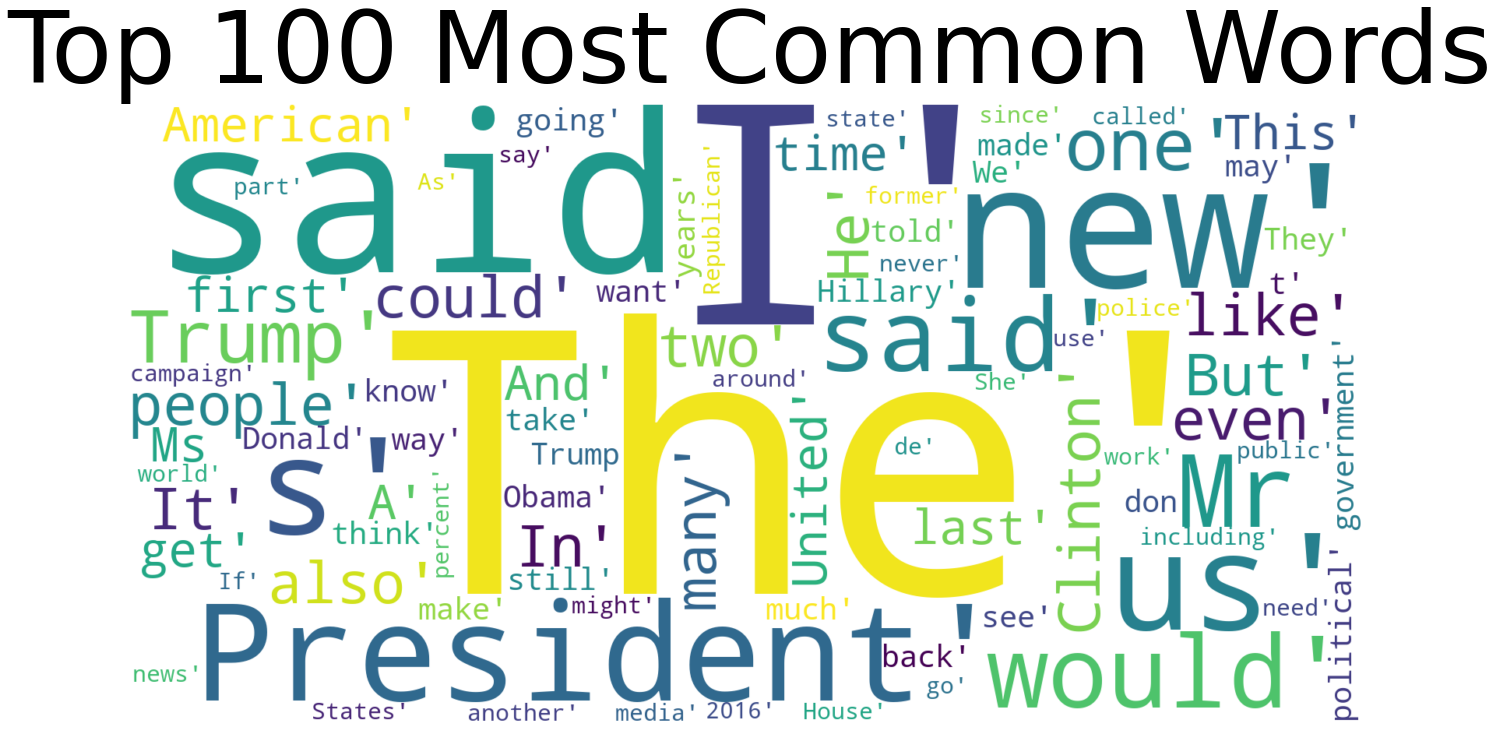

In [ ]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

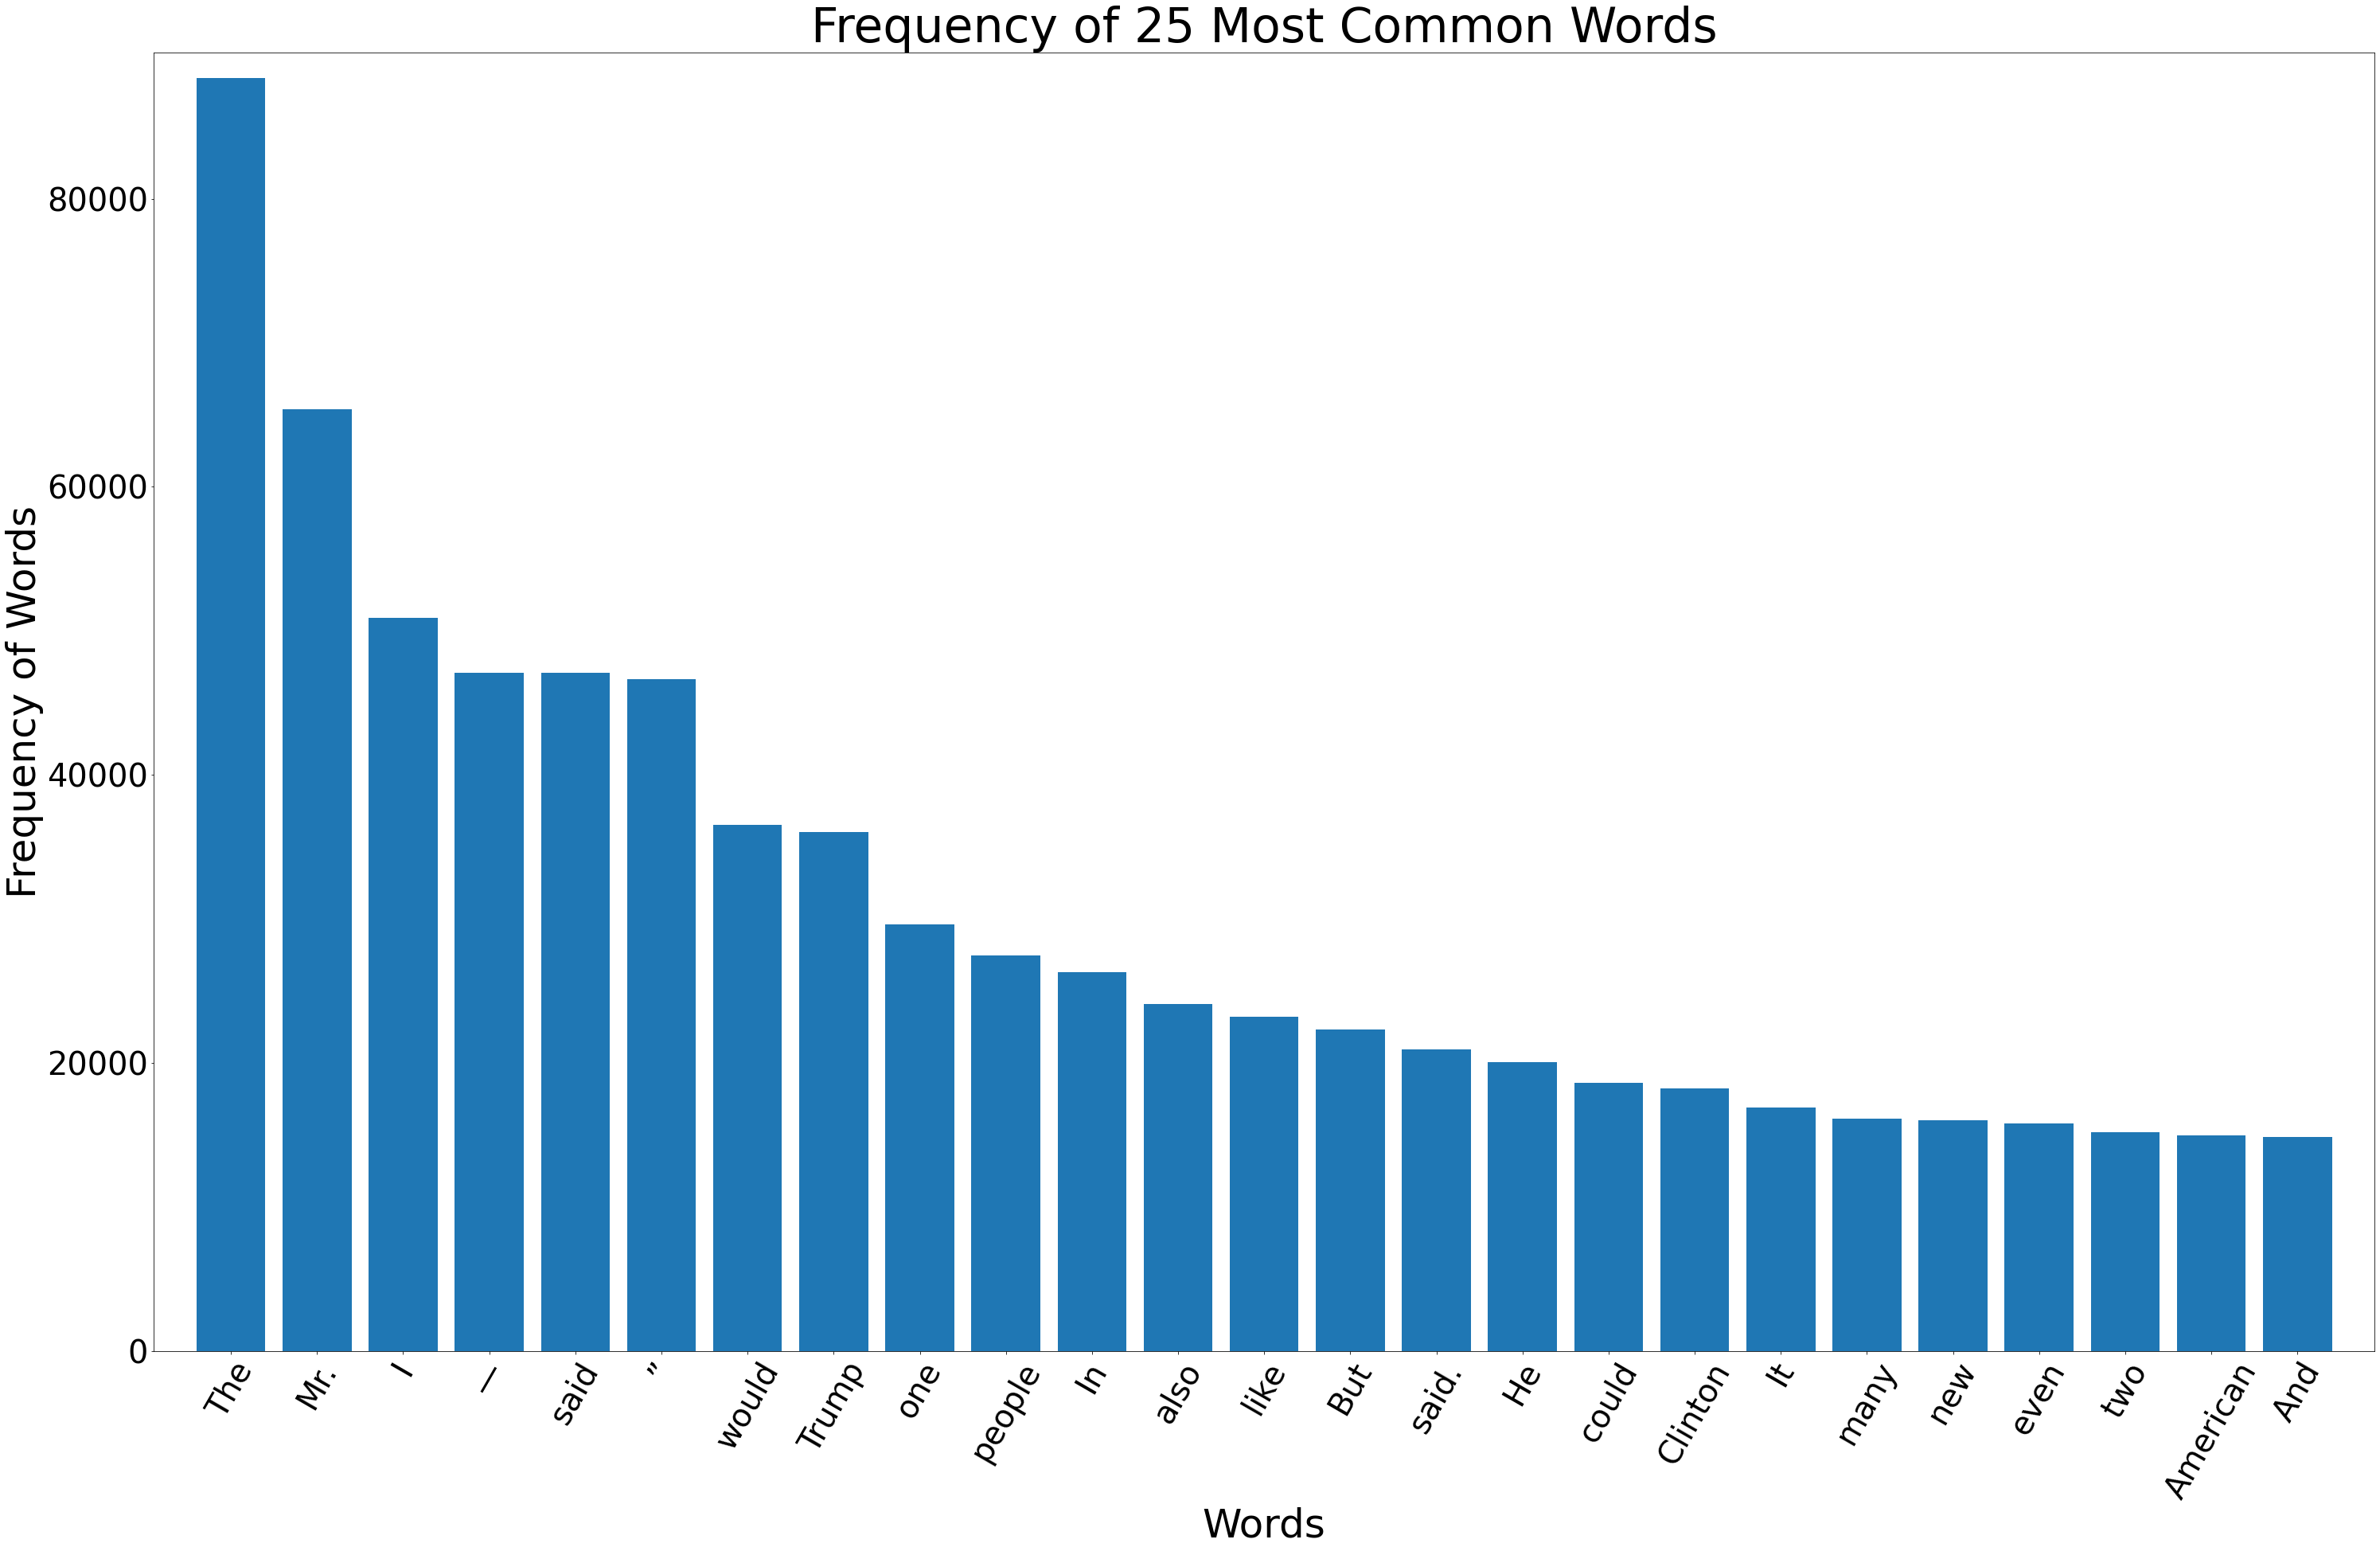

In [57]:
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

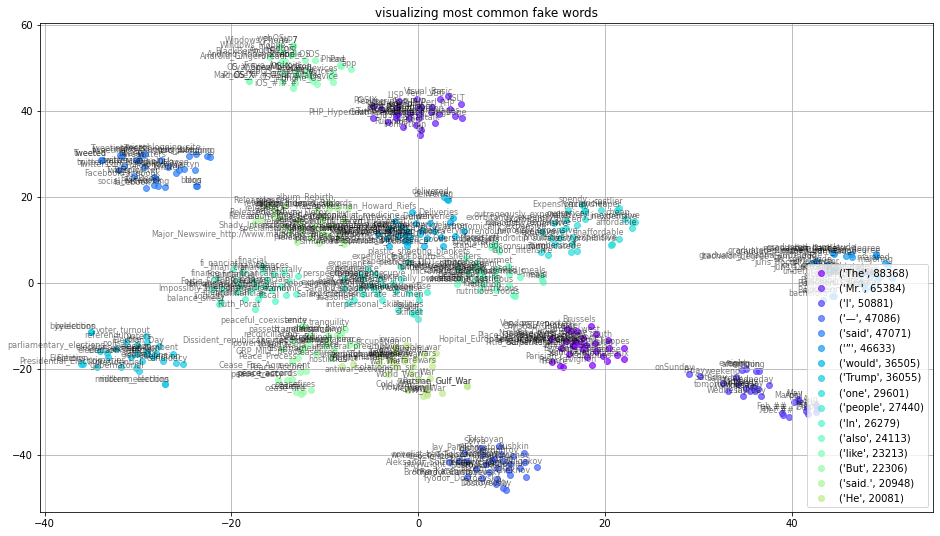

In [58]:
tsne_plot_similar_words('visualizing most common fake words', mostcommon_small, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

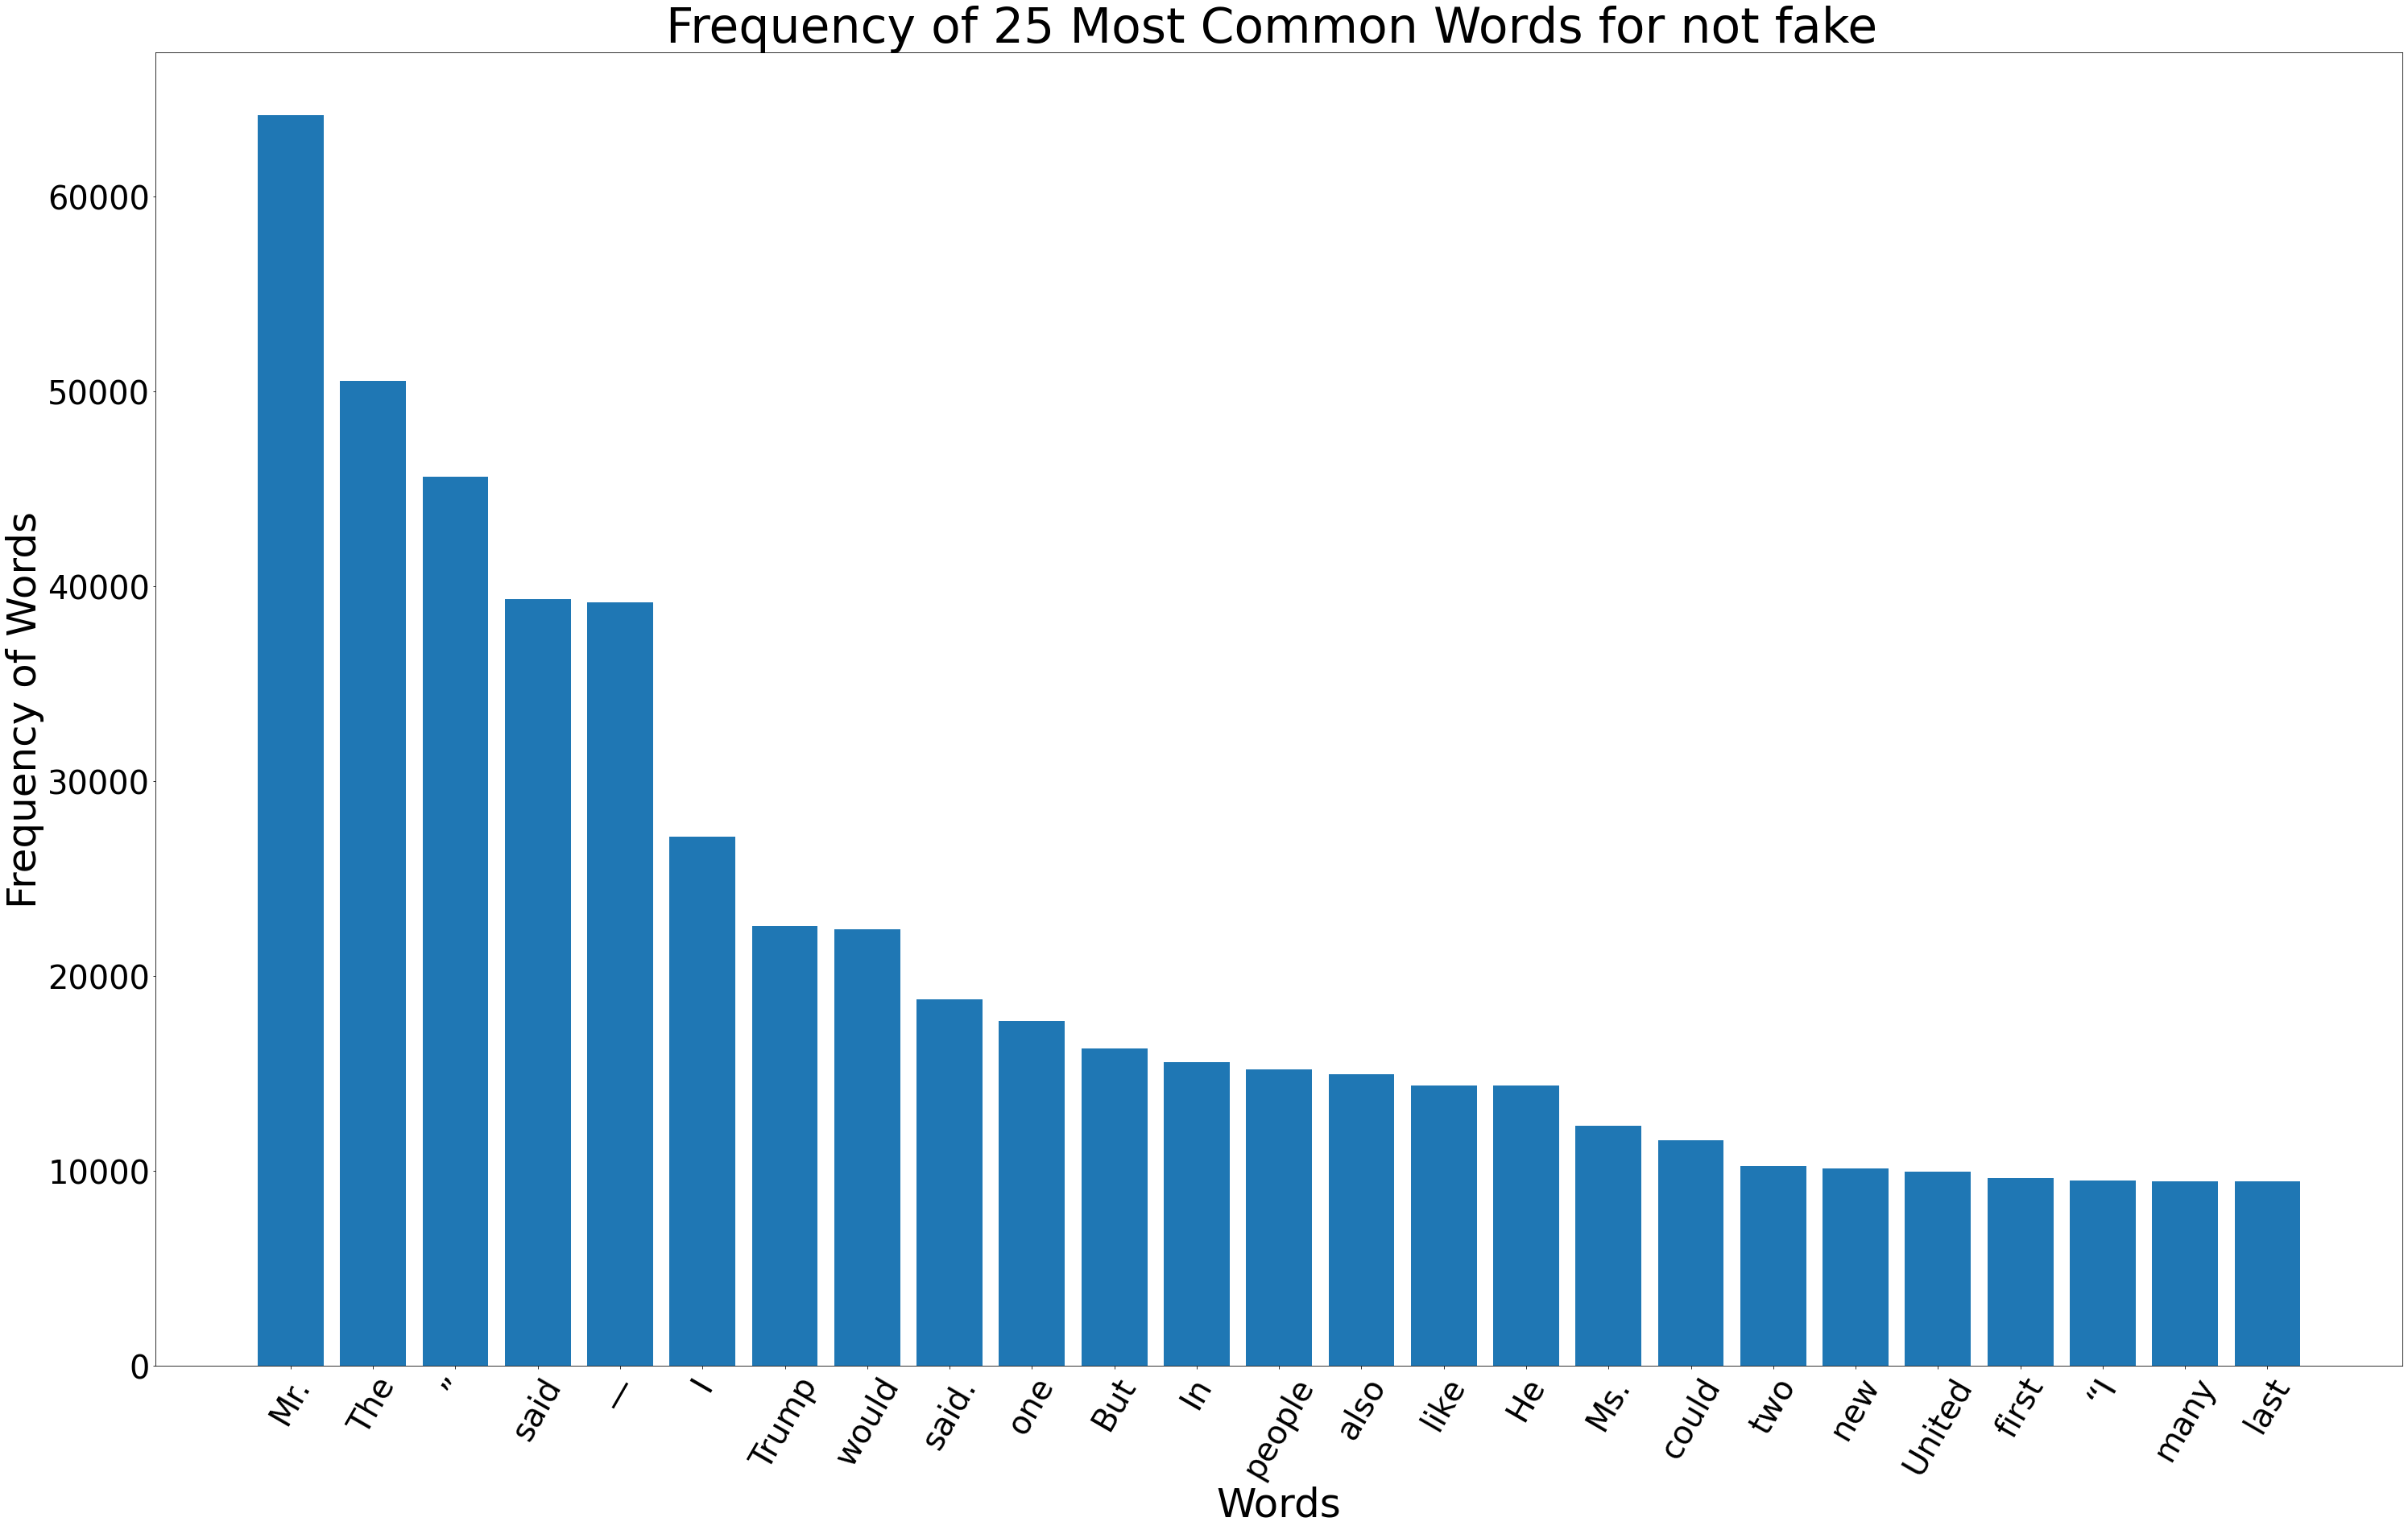

In [59]:
group_by = train_data.groupby('label')['text_processed'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_0 = group_by.iloc[0]
words0 = list(zip(*group_by_0))[0]
freq0 = list(zip(*group_by_0))[1]
plt.figure(figsize=(50,30))
plt.bar(words0, freq0)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for not fake ', fontsize=60)
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

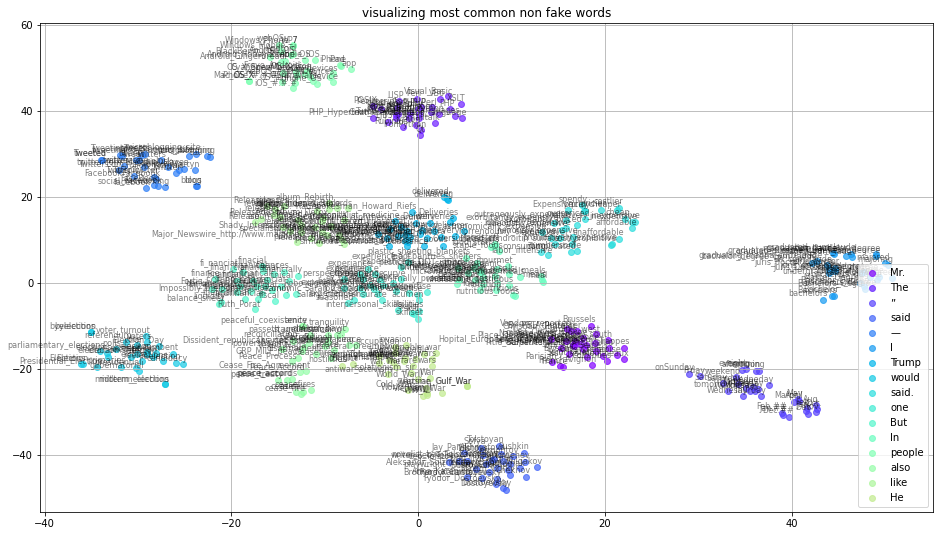

In [60]:
tsne_plot_similar_words('visualizing most common non fake words', words0, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

In [ ]:
tf_vectorizer = CountVectorizer(max_features=50000)
tf = tf_vectorizer.fit_transform(train_data['text_processed'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names()
# doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
# doc_term_matrix

In [ ]:
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=500, random_state=0).fit(tf)
no_top_words = 10
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))
              
display_topics(lda_model, tf_feature_names, no_top_words)

In [ ]:
group_by = train_data.groupby('label')['text_processed'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_0 = group_by.iloc[1]
words0 = list(zip(*group_by_0))[0]
freq0 = list(zip(*group_by_0))[1]
plt.figure(figsize=(50,30))
plt.bar(words0, freq0)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for fake', fontsize=60)
plt.show()

In [ ]:
def max_len(expressions):
    splitted_expressions = []
    splitted_expressions.extend(w.split(' ') for w in expressions)
    maxlen = len(max(splitted_expressions, key=len))
    return maxlen

In [ ]:
def prepare_X_y(df):
    df.dropna(subset = ["text"], inplace=True)
    df['text'].apply(clean_data)
    text = list(df['text'])
    sequences = create_sequences(text)
    maxlen = max_len(text)
    from keras.preprocessing import sequence
    X = sequence.pad_sequences(sequences, maxlen=maxlen, padding='post',
                                              truncating='post')
    y = df['label']
    y_train = np.asarray(y).astype('float32')
    return X , y_train
    
    

In [ ]:
X,y = prepare_X_y(train_data)

In [ ]:
len(X[2])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [ ]:
X_train.shape

In [ ]:

X_train1 = np.expand_dims(X_train, 2)

In [ ]:
X_train1.shape

(13909, 24234, 1)

In [ ]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential() 
    model.add(layers.LSTM(512, input_shape=(24234, 1), return_sequences=True)) 
    model.add(layers.LSTM(128, return_sequences=False))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc']) 
    return model

In [ ]:
model = build_model()
history = model.fit(X_train1, y_train, validation_data=(X_test, y_test),epochs=10, batch_size=12, verbose=1)


Epoch 1/10


In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss'] 
acc = history_dict['acc'] 
val_loss_values = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss') 
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss') 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.clf() 
acc_values = history_dict['acc'] 
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.legend()
plt.show()